In [2]:
import sys
import os
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

#from utils import read_mtx
from plot import plot_embedding, plot_clustercounts

%matplotlib inline


In [9]:
hema=pd.read_csv('data/Hematopoiesis-All/GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt', 
                 sep='\t',header=0, index_col=-1)

In [8]:
hema.head(3)

,UMAP1,UMAP2,Clusters,Group,depth,FRIP,Barcodes,Internal_Name
Group_Barcode,,,,,,,,
Bone_Marrow_Rep1#CAAGAAAGTCAAGACG-1,-2.419656,7.603472,Cluster6,Bone_Marrow_Rep1,29301,0.347190,CAAGAAAGTCAAGACG-1,SUHealthy_BM_B1_50
Bone_Marrow_Rep1#AATGCCATCGCACAAT-1,5.676727,-9.210454,Cluster20,Bone_Marrow_Rep1,7534,0.290948,AATGCCATCGCACAAT-1,SUHealthy_BM_B1_51
Bone_Marrow_Rep1#AAAGGGCAGTACCCAT-1,-7.153399,-5.512960,Cluster11,Bone_Marrow_Rep1,29608,0.449186,AAAGGGCAGTACCCAT-1,SUHealthy_BM_B1_52


In [ ]:
cluster_anno=pd.read_csv('data/Hematopoiesis-All/cluster_anno.txt', sep='\t', header=None, index_col=0)
cluster_anno=cluster_anno[1].to_dict()
hema['ClusterName']=hema.apply(lambda x: cluster_anno[x['Clusters']], axis=1)

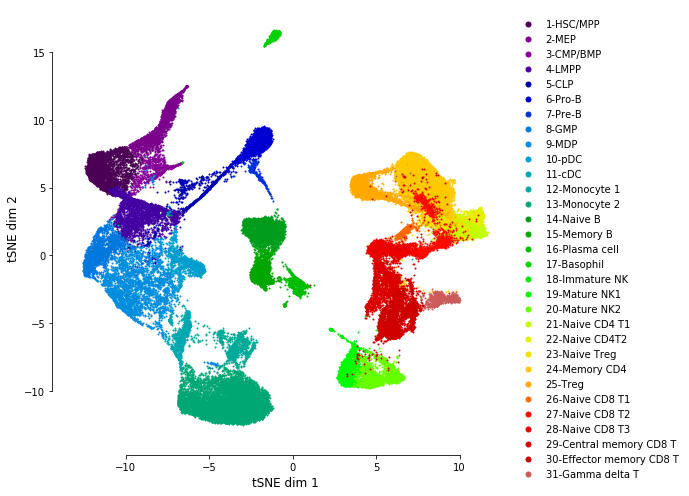

In [70]:
plot_embedding(np.array(hema[['UMAP1','UMAP2']]), hema['ClusterName'], classes=cluster_anno.values(),
               cmap='nipy_spectral', figsize=(8,8),markersize=1)

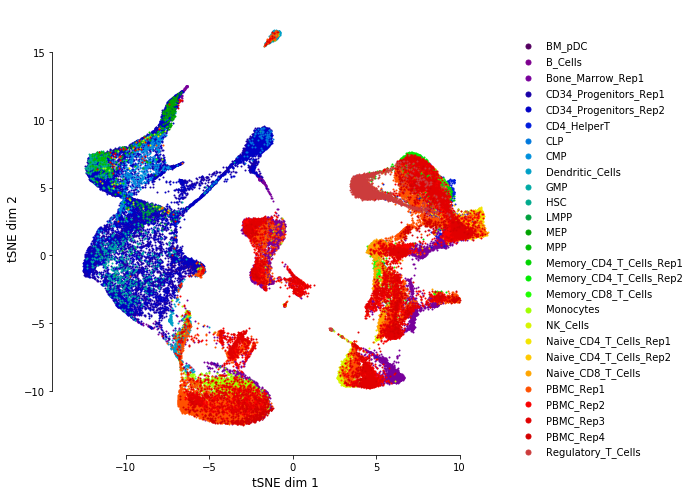

In [42]:
plot_embedding(np.array(hema[['UMAP1','UMAP2']]), hema['Group'], 
               cmap='nipy_spectral', figsize=(8,8),markersize=1)

In [83]:
cluster_counts=hema['ClusterName'].value_counts()
cluster_counts=cluster_counts.loc[cluster_anno.values()]

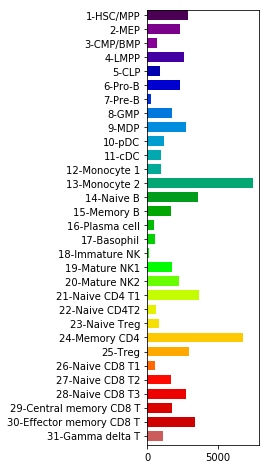

In [99]:
plot_clustercounts(cluster_counts,clusters=list(cluster_anno.values()), 
                   cmap='nipy_spectral',width=0.7,figsize=(2,8),yticks=True)

In [105]:
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix
from glob import glob
import os

def read_anndata(path):
    for filename in glob(path+'/*'):
        basename = os.path.basename(filename)
        if (('count' in basename) or ('matrix' in basename)) and ('mtx' in basename):
            count = mmread(filename)
        elif 'barcode' in basename or 'cell' in basename:
            cell_id = pd.read_csv(filename, sep='\t', header=None)[0].values
        elif 'gene' in basename or 'peak' in basename:
            feature = pd.read_csv(filename, sep='\t', header=None)[0].values
    adata = sc.AnnData(count, feature, cell_id)
    return adata

In [110]:
count = mmread('data/Hematopoiesis-All/GSE129785_scATAC-Hematopoiesis-All.count.mtx')
obs = pd.read_csv('data/Hematopoiesis-All/GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt', sep='\t', header=0, index_col=-1)
var = pd.read_csv('data/Hematopoiesis-All/GSE129785_scATAC-Hematopoiesis-All.peaks.txt', sep='\t', header=0, index_col=0)

In [134]:
count_csr=count.T.tocsr()
print(count_csr[:4,:4])

  (0, 0)	2
  (1, 0)	2
  (2, 0)	2
  (3, 0)	2


In [135]:
print(sys.getsizeof(adata),sys.getsizeof(count),sys.getsizeof(count_csr))

86933946 56 56


In [137]:
adata=sc.AnnData(count_csr, obs=obs, var=var)

In [138]:
sys.getsizeof(adata)

89555290

In [ ]:
adata.obs['clusters']=hema['ClusterName'].values

In [146]:
adata.write('data/Hematopoiesis-All/adata.h5ad')

... storing 'clusters' as categorical


In [3]:
adata=sc.read_h5ad('data/Hematopoiesis-All/adata.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 63882 × 571400 
    obs: 'UMAP1', 'UMAP2', 'Clusters', 'Group', 'depth', 'FRIP', 'Barcodes', 'Internal_Name', 'clusters'
    uns: 'rank_genes_groups'

In [12]:
sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [13]:
adata.write('data/Hematopoiesis-All/adata.h5ad')

In [ ]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=3, standard_scale='var') # MemoryError

# specific features

In [40]:
from plot import plot_heatmap

In [77]:
adata=sc.read_h5ad('result/Hematopoiesis-All/Hematopoiesis-All_adata.h5ad')
specific_genes=pd.DataFrame(adata.uns['rank_genes_groups']['names']).loc[0:20,:].T.values.flatten()
X2=pd.DataFrame(adata[:,specific_genes].X.todense()).T
X2.index=specific_genes
X2.columns=adata.obs['clusters'].values
X2_group=X2.T
X2_group['clusters']=X2_group.index
X2_group=X2_group.groupby('clusters').mean().T
X2=X2_group

In [78]:
y_cluster=np.array([el.split('-')[0] for el in X2.columns])
X2.columns=y_cluster

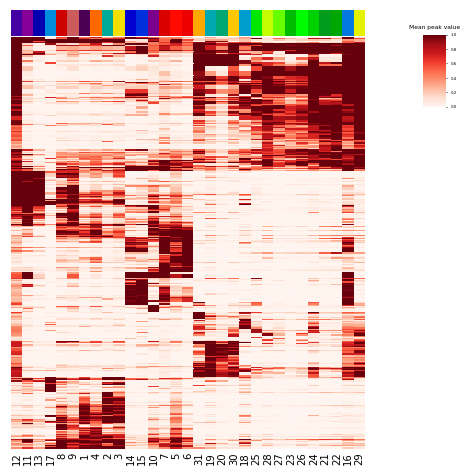

In [41]:
plot_heatmap(X2, y=y_cluster, ncol=3, #row_labels=specific_genes, 
               cmap='Reds' ,colormap=sns.color_palette('nipy_spectral', n_colors=len(y_cluster)),
             vmax=1, row_cluster=True, col_cluster=True,
                 legend_font=6, cax_title='Mean peak value',show_legend=False,
                figsize=(8, 10), bbox_to_anchor=(0.4, 1.2), position=(1, 0.6, .04, .1),
                save=None)

In [84]:
X2.max().max()

3.307539701461792

In [85]:
X2.min().min()

0.0

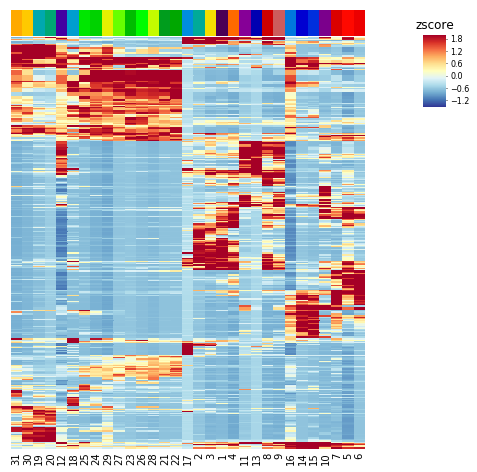

In [86]:
col_colors=sns.color_palette('nipy_spectral', n_colors=len(y_cluster))

plot_heatmap(X2, y=y_cluster, ncol=3, vmax=2, vmin=-1.5,
             row_cluster=True, col_cluster=True, 
             z_score=1, cmap='RdYlBu_r',
             colormap=sns.color_palette('nipy_spectral', n_colors=len(y_cluster)),
            legend_font=6, cax_title='zscore',show_legend=False,
            figsize=(8, 10), bbox_to_anchor=(0.4, 1.2), position=(1, 0.6, .04, .1), 
             save=None)

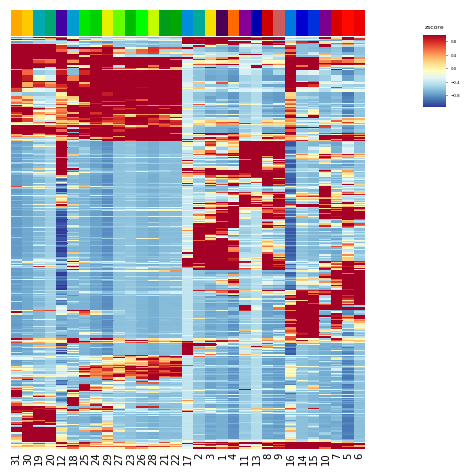

In [55]:
col_colors=sns.color_palette('nipy_spectral', n_colors=len(y_cluster))

plot_heatmap(X2, y=y_cluster, ncol=3, vmax=1, # cluster sorted by class
             row_cluster=True, col_cluster=True, 
             z_score=1, cmap='RdYlBu_r',
             colormap=col_colors,
            legend_font=6, cax_title='zscore',show_legend=False,
            figsize=(8, 10), bbox_to_anchor=(0.4, 1.2), position=(1, 0.6, .04, .1), 
             save='specific_peaks.png')

# TF enrichment

In [24]:
from plot import plot_heatmap

In [6]:
tfdata=pd.read_csv('result/Hematopoiesis-All/chromVAR_f/hema_all_f_dev.txt', sep='\t', header=0, index_col=0)
tfdata.index=[el.split('_')[-1] for el in tfdata.index]
tfdata=sc.AnnData(tfdata.T)

In [7]:
# raw adata is filtered for lack of memory size when running chromVAR
filtered_cells=pd.read_csv('data/Hematopoiesis-All/data_filtered/barcodes.txt', header=None, index_col=0).index

In [ ]:
cluster_anno=pd.read_csv('data//Hematopoiesis-All/Hematopoiesis-All_cluter.txt', sep='\t', header=None, index_col=0)
cluster_anno=cluster_anno[1].to_dict()
hema=pd.read_csv('data/Hematopoiesis-All/GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt', 
                 sep='\t',header=0, index_col=-1)
hema['ClusterName']=hema.apply(lambda x: cluster_anno[x['Clusters']], axis=1)

In [10]:
tfdata.obs_names=list(filtered_cells)
tfdata.obsm['X_umap']=np.array(hema[['UMAP1','UMAP2']].loc[tfdata.obs_names,])
tfdata.obs['cluster']=hema['ClusterName'].loc[tfdata.obs_names]

<Figure size 1080x288 with 0 Axes>

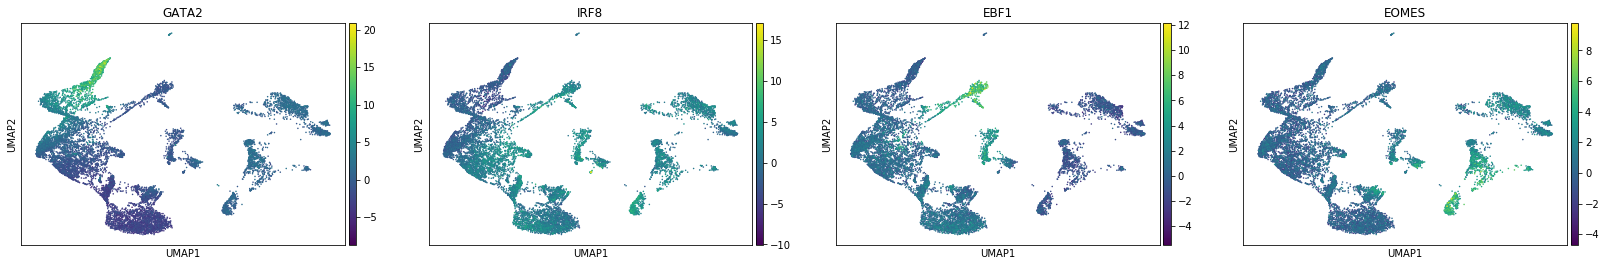

In [51]:
plt.figure(figsize=(15,4))
sc.pl.umap(tfdata, color=['GATA2','IRF8', 'EBF1','EOMES'])#, color_map='nipy_spectral'

In [3]:
# plot heatmap
## choose 250 most variable TFs
var = pd.read_csv('result/Hematopoiesis-All/chromVAR_f/hema_all_f_var.txt', sep='\t', header=0, index_col=0)
var = var [var['p_value_adj']<0.05]
var_sort = var.sort_values(by='variability',ascending=False)
tf_filtered = [el.split('_')[-1] for el in var_sort.index][:250]

In [22]:
tfdata_f = tfdata[:,tf_filtered]

In [87]:
y_cluster=tfdata_f.obs['cluster'].values
X=pd.DataFrame(tfdata_f.X.T, index=tfdata_f.var_names, columns=tfdata_f.obs_names)

In [39]:
np.unique(y_cluster)

array(['1-HSC/MPP', '10-pDC', '11-cDC', '12-Monocyte 1', '13-Monocyte 2',
       '14-Naive B', '15-Memory B', '16-Plasma cell', '17-Basophil',
       '18-Immature NK', '19-Mature NK1', '2-MEP', '21-Naive CD4 T1',
       '22-Naive CD4T2', '23-Naive Treg', '24-Memory CD4', '25-Treg',
       '26-Naive CD8 T1', '27-Naive CD8 T2', '28-Naive CD8 T3',
       '29-Central memory CD8 T', '3-CMP/BMP', '30-Effector memory CD8 T',
       '31-Gamma delta T', '4-LMPP', '5-CLP', '6-Pro-B', '7-Pre-B',
       '8-GMP', '9-MDP'], dtype=object)

In [49]:
X.max().max()

26.690168380737305

In [50]:
X.min().min()

-28.121309280395508

In [88]:
col_cluster=sns.color_palette('nipy_spectral', n_colors=len(y_cluster))
classes = list(cluster_anno.values())

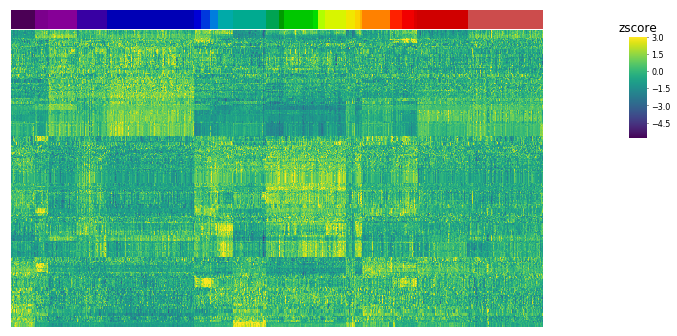

In [90]:
plot_heatmap(X, y_cluster, ncol=3, vmax=3, #vmin=-5,
             row_cluster=True, col_cluster=False, 
             xticklabels=False,
             z_score=0, 
             #cmap='RdYlBu_r',
             #cmap='Spectral',
             cmap='viridis',
             #cmap='inferno',
             colormap=sns.color_palette('nipy_spectral', n_colors=len(np.unique(y_cluster))),
            legend_font=6, cax_title='zscore',show_legend=False,
            figsize=(12, 7), bbox_to_anchor=(0.4, 1.2), position=(1, 0.5, .02, .2), 
             save='result/Hematopoiesis-All/chromVAR_f/dev_heatmap.png')

# cicero gene activity

In [4]:
from utils import read_mtx,read_anndata
import scanpy as sc
import pandas as pd

In [3]:
hema=pd.read_csv('data/Hematopoiesis-All/GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt', 
                 sep='\t',header=0, index_col=-1)

In [6]:
ga = read_anndata('result/Hematopoiesis-All/cicero/ciceroGA/')

ValueError: Shape of passed values is (63882, 1), indices imply (13541, 1)

In [ ]:
ga.obs=hema.loc[ga.obs_names,:]